<a href="https://colab.research.google.com/github/Gooogr/YOLO_toolkit/blob/master/2)TrainCustomYOLOweights_AlexeyAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 import cv2
 from google.colab.patches import cv2_imshow

In [2]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Mon May 25 14:57:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# mount google disk
from google.colab import drive
drive.mount('/content/gdrive')

# create a symbolic sub-link to avoid 'space' problem
!ln -s /content/gdrive/My\ Drive/colab_notebooks/ /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### DarkNet preparations

In [4]:
% cd /mydrive/YOLO_toolkit

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit


In [0]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make

In [0]:
# # Uncomment to make absense darknet from scratch 
# make_darknet()

In [0]:
def download_pretrained_data():
  # YOLOv4
  ! wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
  ! wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
  # Tiny-YOLOv3
  ! wget https://pjreddie.com/media/files/yolov3-tiny.weights

In [0]:
% cd /mydrive/YOLO_toolkit/darknet/
#download_weights()

In [0]:
# Make ./darknet scropt executable from root
! chmod 777 ./darknet

Let's test our darknet detector

In [0]:
def predict_sample():
  % cd /mydrive/YOLO_toolkit/darknet/
  ! chmod 777 ./darknet
  ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/dog.jpg 

# /content/gdrive/My\ Drive/colab_notebooks/
  image = cv2.imread('/mydrive/YOLO_toolkit/darknet/predictions.jpg')
  #resized_image = cv2.resize(image)
  cv2_imshow(image)



/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	         

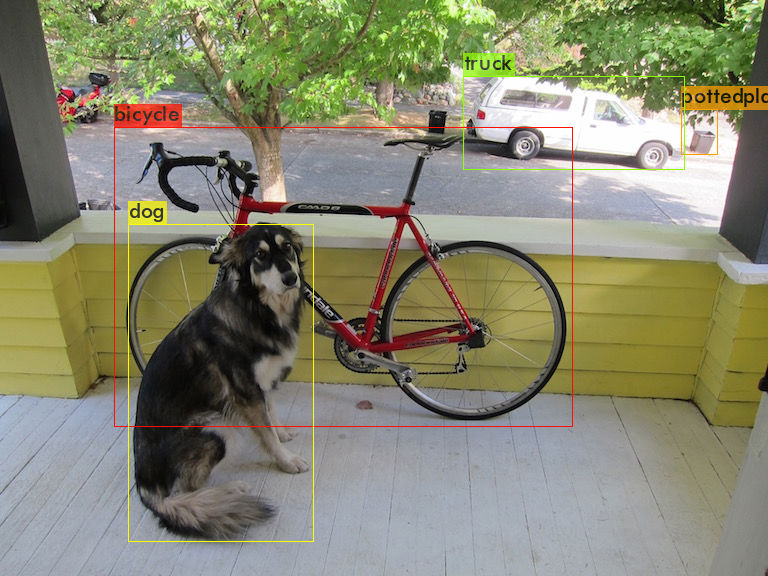

In [26]:
predict_sample()

Also you can edit some code in examples/detector.c. For example change saving weights rules:

Line 139
```
if(i%10000==0 || (i < 1000 && i%100 == 0)){ 
  
if(i%1000==0 || (i < 2000 && i%200 == 0)){ 
```

Don't forget to ```! make``` darknet after that again.

In [27]:
# Create empty directiries for saving weights during the training
! mkdir /mydrive/YOLO_toolkit/yolo_weights


mkdir: cannot create directory ‘/mydrive/YOLO_toolkit/yolo_weights’: File exists


In [28]:
# Create train and test(validate) txt files. Split ratio will be 0.1
% cd /mydrive/YOLO_toolkit/
! python3 splitTrainAndTest.py /mydrive/YOLO_toolkit/Dataset/

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit


In [29]:
! ls /mydrive/YOLO_toolkit

'1)OpenImagesV4Loader.ipynb'		    splitTrainAndTest.py
'2)TrainCustomYOLOweights_AlexeyAB.ipynb'   temp_train.log
'2)TrainCustomYOLOweights.ipynb'	    test_images
'Combine datasets.ipynb'		    test.txt
 darknet				    train.txt
 darknet_files				    VOC2YOLODatasetConverter.py
 Dataset				    yolo_weights
 OIDv4_ToolKit


In [0]:
# Generate anchors for our dataset (we will add them to config file later)


Now we have to edit some files. Go to YOLO_toolkit/darknet_files
> obj.names

Write labels in the same way as in  the classes.txt file. One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

> yolo.data

Specify classes amount. Check pathes to other files but they should be right by default:<br>
classses = *amount of your classes*<br>
valid  = /mydrive/YOLO_toolkit/test.txt<br>
names = /mydrive/YOLO_toolkit/obj.names<br>
backup = /mydrive/YOLO_toolkit/yolo_weights<br>
train  = /mydrive/YOLO_toolkit/train.txt<br>

After that we can compute anchors for our dataset. We will add this information to cfg file

In [32]:
% cd /mydrive/YOLO_toolkit/darknet
! ./darknet detector calc_anchors \
/mydrive/YOLO_toolkit/darknet_files/yolo.data -num_of_clusters 2 -width 416 -height 416 -show

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 2, width = 416, height = 416 
 read labels from 1769 images 
 loaded 	 image: 1769 	 box: 5750
 all loaded. 

 calculating k-means++ ...

 iterations = 9 


counters_per_class = 2571, 3179

 avg IoU = 42.90 % 

Saving anchors to the file: anchors.txt 
anchors =  21, 30,  91,115
Unable to init server: Could not connect: Connection refused

(clusters:2536): Gtk-WARNING **: 16:23:09.089: cannot open display: 


> .cfg files: yolov3_train.cfg/yolov3_predict.cfg or yolov3tiny_train.cfg/yolov3tiny_predict.cfg
How to configure them:

* Comment/uncomment train/test part for specifying batch and subdivisions parameters
* Minimum *maxbatches* = number_of_your_classes * 2000. Of course you can use a bigger values
* *steps* = *maxbatches* * 0.8, *maxbatches* * 0.9
* *classes* = number_of_your_classes
* *filters* = 3 * (*classes*+5)
* *anchors* - replace default numbers by your's

In [34]:
% cd /mydrive/YOLO_toolkit/

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit


In [35]:
! cat darknet_files/obj.names

Human face
Human hand


In [37]:
! cat darknet_files/yolo.data

classes = 2
train  = /mydrive/YOLO_toolkit/train.txt
valid  = /mydrive/YOLO_toolkit/test.txt
names = /mydrive/YOLO_toolkit/darknet_files/obj.names
backup = /mydrive/YOLO_toolkit/yolo_weights




In [38]:
# Get tiny yolo convolutions layers weights
% cd /mydrive/YOLO_toolkit/darknet
! ./darknet partial \
/mydrive/YOLO_toolkit/darknet_files/yolov3tiny_train.cfg \
yolov3-tiny.weights yolov3-tiny.conv.15 15

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 GPU isn't used 
net.optimized_memory = 0 
mini_batch = 1, batch = 2, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 

In [0]:
# Train YOLO
% cd /mydrive/YOLO_toolkit/darknet
! ./darknet detector train \
/mydrive/YOLO_toolkit/darknet_files/yolo.data \
/mydrive/YOLO_toolkit/darknet_files/yolov3tiny_train.cfg \
./yolov3-tiny.conv.15 > /mydrive/YOLO_toolkit/temp_train.log -dont_show  

/content/gdrive/My Drive/colab_notebooks/YOLO_toolkit/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 2, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 

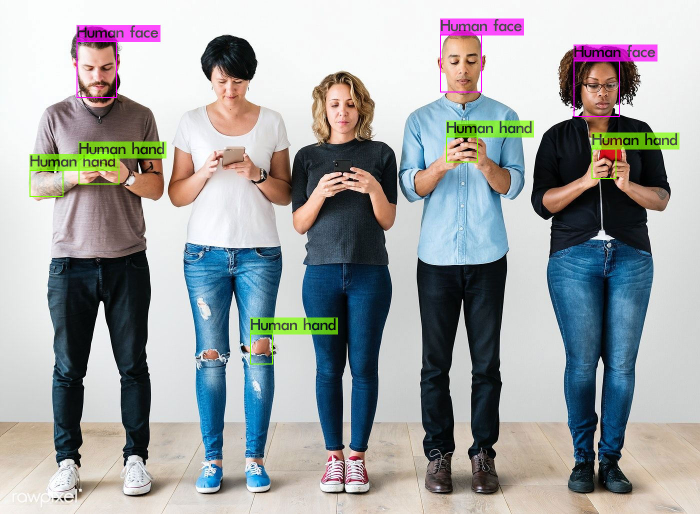

In [56]:
# Predict
% cd /mydrive/YOLO_toolkit/darknet
! chmod 777 ./darknet
!./darknet detector test \
/mydrive/YOLO_toolkit/darknet_files/yolo.data \
/mydrive/YOLO_toolkit/darknet_files/yolov3tiny_train.cfg \
/mydrive/YOLO_toolkit/yolo_weights/yolov3tiny_train_final.weights \
/mydrive/YOLO_toolkit/test_images/group.jpg

image = cv2.imread('/mydrive/YOLO_toolkit/darknet/predictions.jpg')
cv2_imshow(cv2.resize(image, (0, 0), fx=0.5, fy=0.5))